In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [7]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
sns.set()
%matplotlib inline
df = pd.read_csv("AmesHousing.txt", delimiter="\t")
df.shape

(2930, 82)

#### Data Explortary analysis

In [8]:
df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [15]:
# select only columns with numerical values
numerical_df = df.select_dtypes(include = ['int', 'float'])
numerical_df['SalePrice'] = df['SalePrice'].astype(float)
numerical_df.head(2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Lot Frontage,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area,SalePrice
0,141.0,112.0,639.0,0.0,441.0,1080.0,1.0,0.0,1960.0,2.0,528.0,215000.0
1,80.0,0.0,468.0,144.0,270.0,882.0,0.0,0.0,1961.0,1.0,730.0,105000.0


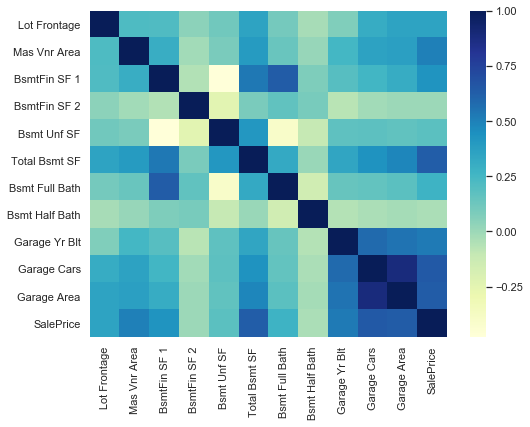

In [16]:
# determing coorelation between columns
cor = numerical_df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(cor, cmap = "YlGnBu")

In [17]:
# rank coorelations with sales price
sale_cor = df.corr()['SalePrice'].sort_values(ascending = False).head(15)
sale_cor

SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Garage Yr Blt     0.526965
Mas Vnr Area      0.508285
TotRms AbvGrd     0.495474
Fireplaces        0.474558
BsmtFin SF 1      0.432914
Name: SalePrice, dtype: float64

In [25]:
def transform_features(df):
    # drop columns with 5% or more missing values 
    num_missing = df.isnull().sum()
    missing_cols = num_missing[(num_missing > len(df)/20)]
    df = df.drop(missing_cols.index, axis=1)
    
    # drop text columns with 1 or more missing values
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum()
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    # fill in numerical columns with the most common value in that column
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)]
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    # create new features
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0) # negative numbers

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df, coeff_threshold = 0.4, uniq_threshold = 10):
    numerical_df = df.select_dtypes(include = ['int', 'float'])
    numerical_df['SalePrice'] = df['SalePrice'].astype(float)
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis = 1)
    
    # List column names that are *meant* to be categorical
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts()))
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    dummy = pd.get_dummies(df.select_dtypes(include=['category']))
    df = pd.concat([df, dummy], axis=1).drop(text_cols,axis=1)
    return df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be

rmse:  57178.20737362906


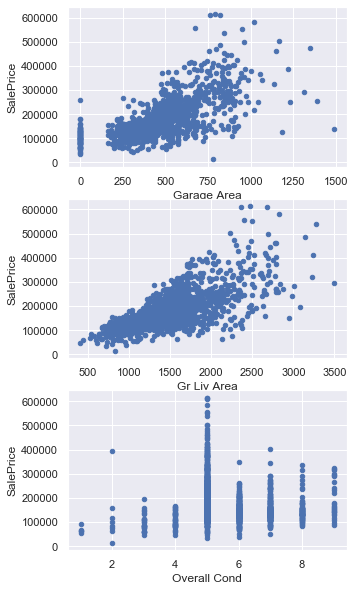

In [28]:
def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    train.plot(x= "Garage Area", y= "SalePrice", ax=ax1, kind= "scatter")
    train.plot(x= "Gr Liv Area", y= "SalePrice", ax=ax2, kind= "scatter")
    train.plot(x= "Overall Cond", y= "SalePrice", ax=ax3, kind= "scatter")
    
    # specify column types and return only those columns as a data frame.
    numeric_train = train.select_dtypes(include = ['integer', 'float'])
    numeric_test = test.select_dtypes(include = ['integer', 'float'])
    numeric_train['SalePrice'] = train['SalePrice'].astype(float)
    numeric_test['SalePrice'] = test['SalePrice'].astype(float)
    
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

df = pd.read_csv("AmesHousing.txt", delimiter= "\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

print('rmse: ', rmse)

In [34]:
# prediction using less features

from sklearn.linear_model import LinearRegression
train = df[:1460]
test = df[1460:]
lr = LinearRegression()
lr.fit(train[['Gr Liv Area']], train['SalePrice'])
from sklearn.metrics import mean_squared_error

train_predictions = lr.predict(train[['Gr Liv Area']])
test_predictions = lr.predict(test[['Gr Liv Area']])

train_mse = mean_squared_error(train_predictions, train['SalePrice'])
test_mse = mean_squared_error(test_predictions, test['SalePrice'])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

56034.362001412796
57088.25161263909


In [35]:
cols = ['Overall Cond', 'Gr Liv Area']
lr = LinearRegression()
lr.fit(train[cols], train['SalePrice'])
from sklearn.metrics import mean_squared_error

train_predictions = lr.predict(train[cols])
test_predictions = lr.predict(test[cols])

train_mse = mean_squared_error(train_predictions, train['SalePrice'])
test_mse = mean_squared_error(test_predictions, test['SalePrice'])

train_rmse_2 = np.sqrt(train_mse)
test_rmse_2 = np.sqrt(test_mse)

print(train_rmse_2)
print(test_rmse_2)

56032.39801525867
57066.90779448559


Text(0, 0.5, 'test_predictions')

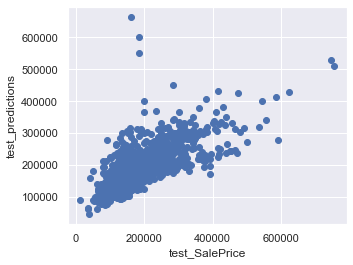

In [48]:
# plt.figure(figsize = (4.3))
plt.figure(figsize=(5,4))
plt.scatter(test['SalePrice'], test_predictions)
plt.xlabel('test_SalePrice')
plt.ylabel('test_predictions')

#### optimization using gradient descent: iteratively trying different parameter values until the model with the lowest mse is found

In [39]:
def derivative(a1, xi_list, yi_list):
    # return the derivative of a1
    
    len_data = len(xi_list)
    error = 0
    for i in range(0, len_data):
        error += xi_list[i]*(a1*xi_list[i] - yi_list[i])
    deriv = 2*error/len_data
    return deriv

def gradient_descent(xi_list, yi_list, max_iterations, alpha, a1_initial):
    a1_list = [a1_initial]

    for i in range(0, max_iterations):
        a1 = a1_list[i]
        deriv = derivative(a1, xi_list, yi_list)
        a1_new = a1 - alpha*deriv
        a1_list.append(a1_new)
    return(a1_list)

param_iterations = gradient_descent(train['Gr Liv Area'], train['SalePrice'], 20, .0000003, 150)
final_param = param_iterations[-1]
print(final_param)

120.14219147202738
